In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Simple Reinforcement Learning with Tensorflow Part 4: Deep Q-Networks and Beyond
# 
# In this iPython notebook I implement a Deep Q-Network using both Double DQN and Dueling DQN. The agent learn to solve a navigation task in a basic grid world. To learn more, read here: https://medium.com/p/8438a3e2b8df
# 
# For more reinforcment learning tutorials, see:
# https://github.com/awjuliani/DeepRL-Agents

# In[1]:


from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
#get_ipython().run_line_magic('matplotlib', 'inline')


# ### Load the game environment

# Feel free to adjust the size of the gridworld. Making it smaller provides an easier task for our DQN agent, while making the world larger increases the challenge.

# In[2]:




/home/fora/anaconda3/envs/RL_test/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fora/anaconda3/envs/RL_test/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fora/anaconda3/envs/RL_test/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fora/anaconda3/envs/RL_test/lib/python3.6/s

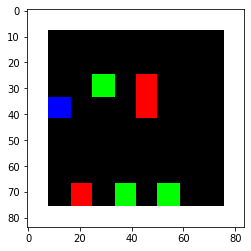

In [2]:
from gridworld import gameEnv

env = gameEnv(partial=False,size=8)

In [3]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [4]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [5]:
def processState(states):
    return np.reshape(states,[21168])

In [6]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [7]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = True #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [8]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Instructions for updating:
Use keras.layers.flatten instead.


Loading Model...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./dqn/model-9999.ckpt
Saved Model
500 -0.4 1
1000 0.5 1
1500 -0.7 1
2000 0.2 1
2500 0.3 1
3000 0.7 1
3500 0.9 1
4000 -0.6 1
4500 -0.8 1
5000 -0.2 1
5500 -1.2 1
6000 -0.6 1
6500 -0.3 1
7000 0.9 1
7500 -0.3 1
8000 -0.1 1
8500 0.2 1
9000 -0.1 1
9500 -0.6 1
10000 0.3 1
10500 -1.1 0.9549999999999828
11000 -0.1 0.9099999999999655
11500 1.6 0.8649999999999483
12000 1.7 0.819999999999931
12500 3.0 0.7749999999999138
13000 2.0 0.7299999999998965
13500 2.9 0.6849999999998793
14000 5.0 0.639999999999862
14500 4.2 0.5949999999998448
15000 5.9 0.5499999999998275
15500 6.5 0.5049999999998103
16000 5.4 0.4599999999998177
16500 6.2 0.41499999999982823
17000 8.2 0.36999999999983874
17500 7.4 0.32499999999984924
18000 9.7 0.27999999999985975
18500 8.5 0.23499999999986562
19000 11.0 0.18999999999986225
19500 13.1 0.14499999999985888
20000 10.4 0.099999999999855

75500 9.9 0.09999999999985551
76000 10.4 0.09999999999985551
76500 8.9 0.09999999999985551
77000 8.9 0.09999999999985551
77500 11.5 0.09999999999985551
78000 11.4 0.09999999999985551
78500 13.0 0.09999999999985551
79000 10.8 0.09999999999985551
79500 10.7 0.09999999999985551
80000 12.3 0.09999999999985551
80500 12.1 0.09999999999985551
81000 10.8 0.09999999999985551
81500 12.0 0.09999999999985551
82000 11.6 0.09999999999985551
82500 12.3 0.09999999999985551
83000 10.2 0.09999999999985551
83500 12.8 0.09999999999985551
84000 13.3 0.09999999999985551
84500 12.8 0.09999999999985551
85000 8.9 0.09999999999985551
85500 9.2 0.09999999999985551
86000 11.0 0.09999999999985551
86500 9.7 0.09999999999985551
87000 11.7 0.09999999999985551
87500 11.1 0.09999999999985551
88000 9.9 0.09999999999985551
88500 11.9 0.09999999999985551
89000 10.9 0.09999999999985551
89500 10.9 0.09999999999985551
90000 9.0 0.09999999999985551
90500 9.8 0.09999999999985551
91000 11.7 0.09999999999985551
91500 9.3 0.09999

204500 12.7 0.09999999999985551
205000 10.8 0.09999999999985551
205500 10.7 0.09999999999985551
206000 10.0 0.09999999999985551
206500 11.8 0.09999999999985551
207000 12.5 0.09999999999985551
207500 12.1 0.09999999999985551
208000 11.4 0.09999999999985551
208500 13.6 0.09999999999985551
209000 12.1 0.09999999999985551
209500 12.9 0.09999999999985551
210000 10.6 0.09999999999985551
210500 13.0 0.09999999999985551
211000 11.8 0.09999999999985551
211500 14.0 0.09999999999985551
212000 11.4 0.09999999999985551
212500 9.2 0.09999999999985551
213000 10.2 0.09999999999985551
213500 12.2 0.09999999999985551
214000 12.3 0.09999999999985551
214500 10.6 0.09999999999985551
215000 11.4 0.09999999999985551
215500 11.7 0.09999999999985551
216000 12.5 0.09999999999985551
216500 12.3 0.09999999999985551
217000 9.5 0.09999999999985551
217500 10.1 0.09999999999985551
218000 13.0 0.09999999999985551
218500 9.4 0.09999999999985551
219000 10.7 0.09999999999985551
219500 13.4 0.09999999999985551
220000 11.0

327500 12.2 0.09999999999985551
328000 11.1 0.09999999999985551
328500 10.5 0.09999999999985551
329000 13.0 0.09999999999985551
329500 12.2 0.09999999999985551
330000 11.0 0.09999999999985551
330500 11.6 0.09999999999985551
331000 12.3 0.09999999999985551
331500 8.9 0.09999999999985551
332000 10.3 0.09999999999985551
332500 12.1 0.09999999999985551
333000 11.0 0.09999999999985551
333500 11.5 0.09999999999985551
334000 12.5 0.09999999999985551
334500 12.5 0.09999999999985551
335000 11.1 0.09999999999985551
335500 11.7 0.09999999999985551
336000 9.3 0.09999999999985551
336500 11.9 0.09999999999985551
337000 12.2 0.09999999999985551
337500 11.0 0.09999999999985551
338000 11.9 0.09999999999985551
338500 8.8 0.09999999999985551
339000 10.8 0.09999999999985551
339500 11.5 0.09999999999985551
340000 10.5 0.09999999999985551
340500 12.8 0.09999999999985551
341000 14.0 0.09999999999985551
341500 11.2 0.09999999999985551
342000 12.0 0.09999999999985551
342500 12.9 0.09999999999985551
343000 13.6

455500 14.8 0.09999999999985551
456000 12.2 0.09999999999985551
456500 12.5 0.09999999999985551
457000 12.6 0.09999999999985551
457500 11.4 0.09999999999985551
458000 13.8 0.09999999999985551
458500 10.0 0.09999999999985551
459000 11.1 0.09999999999985551
459500 10.9 0.09999999999985551
460000 8.3 0.09999999999985551
460500 13.6 0.09999999999985551
461000 11.1 0.09999999999985551
461500 11.5 0.09999999999985551
462000 11.4 0.09999999999985551
462500 13.3 0.09999999999985551
463000 12.2 0.09999999999985551
463500 11.9 0.09999999999985551
464000 10.8 0.09999999999985551
464500 13.1 0.09999999999985551
465000 10.3 0.09999999999985551
465500 13.4 0.09999999999985551
466000 12.2 0.09999999999985551
466500 12.5 0.09999999999985551
467000 13.8 0.09999999999985551
467500 12.4 0.09999999999985551
468000 11.1 0.09999999999985551
468500 13.2 0.09999999999985551
469000 13.5 0.09999999999985551
469500 12.4 0.09999999999985551
470000 9.1 0.09999999999985551
470500 14.5 0.09999999999985551
471000 14.

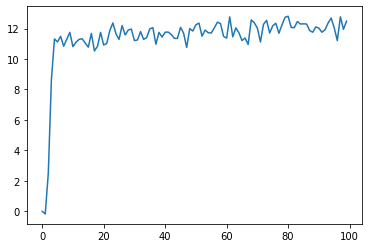

In [9]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)